# Необходимые библиотеки

In [1]:
# pip install sentence_transformers
# pip install fasttext
# pip install pymorphy2
# pip install xgboost
# pip install imblearn
# pip install textattack
# pip install transformers
# pip install catboost

In [55]:
from datasets import load_dataset

from sentence_transformers import SentenceTransformer
from transformers import pipeline

# import textattack
# from textattack.augmentation import WordNetAugmenter

# import fasttext
# import fasttext.util

# import re
# import pymorphy2

import pandas as pd
import numpy as np
# from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from scipy.spatial import distance


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ndcg_score, average_precision_score, roc_curve, auc

# Обработка данных

## Просто загрузка всех датасетов

In [2]:
dataset_train = load_dataset("cohere/miracl-ru-queries-22-12", split="train")
dataset_dev = load_dataset("cohere/miracl-ru-queries-22-12", split="dev")

In [3]:
train_dataset= dataset_train.to_pandas().drop(columns=['emb'])
test_dataset = dataset_dev.to_pandas().drop(columns=['emb'])

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4683 entries, 0 to 4682
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query_id           4683 non-null   object
 1   query              4683 non-null   object
 2   positive_passages  4683 non-null   object
 3   negative_passages  4683 non-null   object
dtypes: object(4)
memory usage: 146.5+ KB


In [5]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query_id           1252 non-null   object
 1   query              1252 non-null   object
 2   positive_passages  1252 non-null   object
 3   negative_passages  1252 non-null   object
dtypes: object(4)
memory usage: 39.2+ KB


## Выделим отсюда train/dev/test

In [6]:
df_train = train_dataset[:4155]
df_val = pd.concat([train_dataset[4155:-200],test_dataset[:362], test_dataset[-200:]])
df_test = pd.concat([train_dataset[-200:], test_dataset[362:-200]])

In [7]:
print(df_train.shape, df_val.shape, df_test.shape)

(4155, 4) (890, 4) (890, 4)


In [8]:
# df_testA = load_dataset("cohere/miracl-ru-queries-22-12", split="testA").to_pandas()
# df_testB = load_dataset("cohere/miracl-ru-queries-22-12", split="testB").to_pandas()

In [9]:
# df_testA.info()

In [10]:
# df_testB.info()

Количество сэмплов сходится с заявленным на странице датасета
(на последний номер строки данных на сайте смотреть, видимо, не стоит, объектов 4.68k, 1.25k, 911, 718)

In [11]:
# df_train.drop(columns=['emb', 'query_id'], axis = 0, inplace=True)
# df_test.drop(columns=['emb', 'query_id'], axis = 0, inplace=True)

## Предобработка текста

## Аугментация

### Лемматизация queries

In [12]:
# Инициализация лемматизатора
# morph = pymorphy2.MorphAnalyzer()

# # Функция для очистки и лемматизации текста
# def clean_and_lemmatize(text):
#     # Удаление спецсимволов, кроме букв и пробелов
#     text = re.sub(r'[^а-яА-Я\s]', '', text)
#     # Лемматизация
#     words = text.split()
#     lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
#     return ' '.join(lemmatized_words)

In [13]:
# df_train['query'] = df_train['query'].apply(clean_and_lemmatize)
# df_test['query'] = df_test['query'].apply(clean_and_lemmatize)

In [14]:
# df_train.drop(columns = 'query_id', inplace = True)
# df_test.drop(columns = 'query_id', inplace = True)

In [15]:
# df_train.head()

### Кодировка queries в embeddings

In [16]:
# Загрузка предобученной модели
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [17]:
query_embeddings_train = model.encode(df_train['query'].tolist())
query_embeddings_val = model.encode(df_val['query'].tolist())
query_embeddings_test = model.encode(df_test['query'].tolist())

In [18]:
np.save("query_embeddings_train_SBERT_without_lemma.npy", query_embeddings_train)
np.save("query_embeddings_val_SBERT_without_lemma.npy", query_embeddings_val)
np.save("query_embeddings_test_SBERT_without_lemma.npy", query_embeddings_test)

In [19]:
query_embeddings_train = np.load("query_embeddings_train_SBERT_without_lemma.npy").tolist()
query_embeddings_val = np.load("query_embeddings_val_SBERT_without_lemma.npy").tolist()
query_embeddings_test = np.load("query_embeddings_test_SBERT_without_lemma.npy").tolist()

In [20]:
df_train['query_emb'] = list(query_embeddings_train)
df_val['query_emb'] = list(query_embeddings_val)
df_test['query_emb'] = list(query_embeddings_test)

/var/folders/60/21xj966x6f19sn3n9pv_16s00000gn/T/ipykernel_2927/4161437826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['query_emb'] = list(query_embeddings_train)


## Преобразуем данные в нормальный вид

In [21]:
# Функция для создания строк с query, passage и label
def create_rows_from_passages(row):
    new_rows = []
    query = row['query_emb']

    # Обработка positive_passages
    for pos_passage in row['positive_passages']:
        new_rows.append({
            'query_emb': query,
            'query_id': row['query_id'],
            'passage_text': pos_passage['text'], 
            'label': 1
        })
        

    # Обработка negative_passages
    for neg_passage in row['negative_passages']:
        new_rows.append({
            'query_emb': query,
            'query_id': row['query_id'],
            'passage_text': neg_passage['text'],
            'label': 0
        })

    return new_rows

In [22]:
# Применение функции ко всему DataFrame
new_rows = []
for index, row in df_train.iterrows():
    new_rows.extend(create_rows_from_passages(row))

# Создание нового DataFrame
df_train = pd.DataFrame(new_rows)

# Применение функции ко всему DataFrame
new_rows = []
for index, row in df_test.iterrows():
    new_rows.extend(create_rows_from_passages(row))

# Создание нового DataFrame
df_test = pd.DataFrame(new_rows)

# Применение функции ко всему DataFrame
new_rows = []
for index, row in df_val.iterrows():
    new_rows.extend(create_rows_from_passages(row))

# Создание нового DataFrame
df_val = pd.DataFrame(new_rows)

In [23]:
df_train.head()

,query_emb,query_id,passage_text,label
0,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1
1,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,Стерегу́щий — русский миноносец типа «Сокол». ...,0
2,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,Эскадренный миноносец заложен в 1900 году на Н...,0
3,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,10 октября 1937 года эсминец был спущен на вод...,0
4,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,В 1901 году миноносец «Бодрый» был зачислен в ...,0


In [24]:
df_test.head()

,query_emb,query_id,passage_text,label
0,"[0.23910459876060486, -0.07795657217502594, -0...",6460,Нильский крокодил имеет очень хороший слух и б...,1
1,"[-0.3060879409313202, 0.11083514988422394, -0....",6461,Окончил Институт стран Азии и Африки при МГУ. ...,1
2,"[0.09404715150594711, 0.2521896958351135, 0.03...",6462,Наде́жда Андре́евна Толоко́нникова (род. 7 ноя...,1
3,"[0.1350945681333542, -0.04774768278002739, -0....",6464,"23 января 2007 года, ровно через год после ано...",1
4,"[0.1350945681333542, -0.04774768278002739, -0....",6464,23 января 2006 года Crytek официально анонсиру...,0


In [25]:
df_val.head()

,query_emb,query_id,passage_text,label
0,"[-0.157792866230011, -0.05028054118156433, -0....",5946,"«Великий перелом» — выражение И. В. Сталина, к...",1
1,"[0.2644612491130829, 0.02110552228987217, -0.1...",5947,В общей сложности во времена Третьего рейха по...,1
2,"[-0.11755678802728653, 0.5367297530174255, -0....",5948,Михаил Михайлович Сперанский родился 1 января ...,1
3,"[0.1772700399160385, -0.10720376670360565, 0.0...",5949,Башкирский язык ( ) — один из тюркских языков ...,1
4,"[-0.09927018731832504, 0.27825474739074707, 0....",5950,"Документы XVII века, называют Львов первым гор...",1


In [26]:
df_val['label'].value_counts()[1]/df_val['label'].value_counts()[0]

0.45063879210220675

In [27]:
df_train['label'].value_counts()[1]/df_train['label'].value_counts()[0]

0.39531380753138073

In [28]:
df_test['label'].value_counts()[1]/df_test['label'].value_counts()[0]

0.4132420091324201

### Лемматизация пассажей

In [29]:
# df_train['passage_text'] = df_train['passage_text'].apply(clean_and_lemmatize)
# df_test['passage_text'] = df_test['passage_text'].apply(clean_and_lemmatize)

### Кодировка passages

In [30]:
# Кодирование пассажей
passage_embeddings_train = model.encode(df_train['passage_text'].tolist())
passage_embeddings_val = model.encode(df_val['passage_text'].tolist())
passage_embeddings_test = model.encode(df_test['passage_text'].tolist())

In [31]:
np.save("passage_embeddings_train_SBERT_without_lemma.npy", passage_embeddings_train)
np.save("passage_embeddings_val_SBERT_without_lemma.npy", passage_embeddings_val)
np.save("passage_embeddings_test_SBERT_without_lemma.npy", passage_embeddings_test)

In [32]:
passage_embeddings_train = np.load("passage_embeddings_train_SBERT_without_lemma.npy").tolist()
passage_embeddings_val = np.load("passage_embeddings_val_SBERT_without_lemma.npy").tolist()
passage_embeddings_test =  np.load("passage_embeddings_test_SBERT_without_lemma.npy").tolist()

In [33]:
df_train['passage_emb'] = list(passage_embeddings_train)
df_val['passage_emb'] = list(passage_embeddings_val)
df_test['passage_emb'] = list(passage_embeddings_test)

In [34]:
df_train.drop(columns = 'passage_text', inplace = True)
df_val.drop(columns = 'passage_text', inplace = True)
df_test.drop(columns = 'passage_text', inplace = True)

## Другие варианты кодировки

In [35]:
# # Загрузка модели FastText
# fasttext.util.download_model('ru', if_exists='ignore') 
# model = fasttext.load_model('cc.ru.300.bin')

In [36]:
# # кодировка пассажей
# passage_embeddings_train =[model.get_sentence_vector(passage) for passage in df_train['passage_text'].tolist()]
# passage_embeddings_test = [model.get_sentence_vector(passage) for passage in df_test['passage_text'].tolist()]

# query_embeddings_train = [model.get_sentence_vector(passage) for passage in df_train['query_text'].tolist()]
# query_embeddings_test = [model.get_sentence_vector(passage) for passage in df_test['query_text'].tolist()]

In [37]:
# # Сохраняем эмбеддинги в файлы
# np.save("passage_embeddings_train_FAST.npy", passage_embeddings_train)
# np.save("passage_embeddings_test_FAST.npy", passage_embeddings_test)
# np.save("query_embeddings_train_FAST.npy", query_embeddings_train)
# np.save("query_embeddings_test_FAST.npy", query_embeddings_test)

## Финальный вид датасетов

In [38]:
df_train.head()

,query_emb,query_id,label,passage_emb
0,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,1,"[-0.2847347855567932, 0.24554172158241272, -0...."
1,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.19520770013332367, 0.1378668248653412, -0...."
2,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.1887834370136261, 0.15527963638305664, -0...."
3,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.21765783429145813, 0.21826159954071045, -0..."
4,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.12288299947977066, 0.05616552382707596, -0..."


In [39]:
df_val.head()

,query_emb,query_id,label,passage_emb
0,"[-0.157792866230011, -0.05028054118156433, -0....",5946,1,"[-0.3634912371635437, 0.11522447317838669, -0...."
1,"[0.2644612491130829, 0.02110552228987217, -0.1...",5947,1,"[0.1161414384841919, -0.015308648347854614, -0..."
2,"[-0.11755678802728653, 0.5367297530174255, -0....",5948,1,"[-0.057527028024196625, 0.20991000533103943, -..."
3,"[0.1772700399160385, -0.10720376670360565, 0.0...",5949,1,"[-0.05495113506913185, -0.22787174582481384, -..."
4,"[-0.09927018731832504, 0.27825474739074707, 0....",5950,1,"[-0.175890251994133, 0.2675669491291046, 0.006..."


In [40]:
df_test.head()

,query_emb,query_id,label,passage_emb
0,"[0.23910459876060486, -0.07795657217502594, -0...",6460,1,"[-0.07157477736473083, -0.1256970465183258, 0...."
1,"[-0.3060879409313202, 0.11083514988422394, -0....",6461,1,"[-0.30993688106536865, 0.3076673150062561, 0.3..."
2,"[0.09404715150594711, 0.2521896958351135, 0.03...",6462,1,"[-0.06444382667541504, -0.02644665166735649, -..."
3,"[0.1350945681333542, -0.04774768278002739, -0....",6464,1,"[-0.3528747260570526, -0.014291850849986076, 0..."
4,"[0.1350945681333542, -0.04774768278002739, -0....",6464,0,"[-0.3528507947921753, -0.0938614010810852, 0.2..."


In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33348 entries, 0 to 33347
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query_emb    33348 non-null  object
 1   query_id     33348 non-null  object
 2   label        33348 non-null  int64 
 3   passage_emb  33348 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [42]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6245 entries, 0 to 6244
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query_emb    6245 non-null   object
 1   query_id     6245 non-null   object
 2   label        6245 non-null   int64 
 3   passage_emb  6245 non-null   object
dtypes: int64(1), object(3)
memory usage: 195.3+ KB


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7428 entries, 0 to 7427
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query_emb    7428 non-null   object
 1   query_id     7428 non-null   object
 2   label        7428 non-null   int64 
 3   passage_emb  7428 non-null   object
dtypes: int64(1), object(3)
memory usage: 232.2+ KB


# Обучение модели

## Обучение различных моделей

In [44]:
# Функция для подсчёта nDCG по группам
def calculate_ndcg_by_group(y_true, y_pred, groups):
    unique_groups = np.unique(groups)
    ndcg_scores = []
    
    for group in unique_groups:
        # Выбираем данные только для текущей группы
        group_indices = np.where(groups == group)
        y_true_group = y_true[group_indices]
        y_pred_group = y_pred[group_indices]
        
        # Считаем nDCG для текущей группы
        if len(y_true_group) > 1: 
            ndcg = ndcg_score([y_true_group], [y_pred_group])
            ndcg_scores.append(ndcg)
    
    # Возвращаем средний nDCG по всем группам
    return np.mean(ndcg_scores)

def evaluate(y_pred, y_test, group_test):
    ap = average_precision_score(y_test, y_pred)
    print(f"Average Precision: {ap:.4f}")

    # Подсчёт nDCG по группам
    ndcg = calculate_ndcg_by_group(y_test, y_pred, group_test)
    print(f"nDCG: {ndcg:.4f}")

    # Рассчитываем значения для ROC-кривой
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Вычисляем AUC (площадь под ROC-кривой)
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Построение графика ROC-кривой
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [52]:
# Функция для расчета различных мер близости
def calculate_similarity_measures(query_emb, passage_emb):
    # Косинусная близость
    cosine_sim = 1 - distance.cosine(query_emb, passage_emb)
    
    # Евклидово расстояние
    euclidean_dist = distance.euclidean(query_emb, passage_emb)
    
    # Манхэттенское расстояние
    manhattan_dist = distance.cityblock(query_emb, passage_emb)
    
    # Дот-продукт
    dot_product = np.dot(query_emb, passage_emb)
    
    # Чебышёвское расстояние
    chebyshev_dist = distance.chebyshev(query_emb, passage_emb)
    
    return {
        'cosine_sim': cosine_sim,
        'euclidean_dist': euclidean_dist,
        'manhattan_dist': manhattan_dist,
        'dot_product': dot_product,
        'chebyshev_dist': chebyshev_dist
    }

# Функция для добавления столбцов с мерами близости в датасет
def add_similarity_measures(df):
    df['similarity_measures'] = df.apply(
        lambda row: calculate_similarity_measures(row['query_emb'], row['passage_emb']), axis=1
    )
    df = pd.concat([df, df['similarity_measures'].apply(pd.Series)], axis=1)
    df = df.drop(columns=['similarity_measures'])
    return df

# Функция для создания X, y и group с возможностью добавления других столбцов
def prepare_data(df, query_emb_col='query_emb', passage_emb_col='passage_emb', label_col='label', query_id_col='query_id', additional_emb_cols=None):
    # Стек эмбеддингов запросов и документов
    X = np.hstack((np.stack(df[query_emb_col].values), np.stack(df[passage_emb_col].values)))
    
    # Если есть дополнительные эмбеддинги (или метрики), добавляем их
    if additional_emb_cols:
        for col in additional_emb_cols:
            # Преобразуем одномерные метрики в двумерные с помощью reshape
            additional_data = np.stack(df[col].values).reshape(-1, 1)
            X = np.hstack((X, additional_data))
    
    # Метки классов
    y = df[label_col].values
    
    # Идентификаторы запросов
    group = df[query_id_col].values
    
    return X, y, group

In [46]:
# Применяем ко всем наборам данных
df_train = add_similarity_measures(df_train)
df_test = add_similarity_measures(df_test)
df_val = add_similarity_measures(df_val)

In [47]:
# Сохранение DataFrame в Pickle
df_train.to_pickle('train_data.pkl')
df_val.to_pickle('val_data.pkl')
df_test.to_pickle('test_data.pkl')


In [48]:
# Загрузка DataFrame из Pickle
df_train = pd.read_pickle('train_data.pkl')
df_val = pd.read_pickle('val_data.pkl')
df_test = pd.read_pickle('test_data.pkl')

In [49]:
df_train.head()

,query_emb,query_id,label,passage_emb,cosine_sim,euclidean_dist,manhattan_dist,dot_product,chebyshev_dist
0,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,1,"[-0.2847347855567932, 0.24554172158241272, -0....",0.446730,3.527385,55.727232,4.915402,0.505052
1,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.19520770013332367, 0.1378668248653412, -0....",0.573823,2.993298,47.010054,5.427258,0.439354
2,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.1887834370136261, 0.15527963638305664, -0....",0.644053,2.774079,43.538279,6.290825,0.475921
3,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.21765783429145813, 0.21826159954071045, -0...",0.476667,3.343977,53.775488,4.829671,0.466329
4,"[-0.11629089713096619, 0.363239586353302, -0.0...",1,0,"[-0.12288299947977066, 0.05616552382707596, -0...",0.432538,3.409559,54.147868,4.085761,0.478718


**Линейная регрессия**

In [53]:
# Применяем ко всем наборам данных, добавляем необходимые метрики
additional_emb_columns = ['euclidean_dist', 'manhattan_dist', 'dot_product', 'chebyshev_dist']

X_train, y_train, group_train = prepare_data(df_train, additional_emb_cols=additional_emb_columns)
X_val, y_val, group_val = prepare_data(df_val, additional_emb_cols=additional_emb_columns)
X_test, y_test, group_test = prepare_data(df_test, additional_emb_cols=additional_emb_columns)

In [59]:
# Определение гиперпараметров для перебора
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # коэффициент регуляризации
    'solver': ['liblinear', 'lbfgs'],  # выбор алгоритма
}

# Функция для подбора гиперпараметров и обучения модели
def train_and_evaluate(X_train, y_train, X_val, y_val, group_val, param_grid):
    best_ndcg = 0
    best_model = None
    best_params = None
    
    for C in param_grid['C']:
        for solver in param_grid['solver']:
            # Инициализация модели с текущими гиперпараметрами
            model = LogisticRegression(C=C, solver=solver, class_weight='balanced', max_iter=10000)
            
            # Обучение модели
            model.fit(X_train, y_train)
            
            # Предсказание вероятностей для валидационного набора
            y_pred_prob = model.predict_proba(X_val)[:, 1]
            
            # Подсчёт nDCG по группам
            ndcg = calculate_ndcg_by_group(y_val, y_pred_prob, group_val)
            
            print(f"nDCG: {ndcg:.4f}, C: {C}, Solver: {solver}")
            
            # Сохранение наилучшей модели по nDCG
            if ndcg > best_ndcg:
                best_ndcg = ndcg
                best_model = model
                best_params = {'C': C, 'solver': solver}
    
    print(f"Best nDCG: {best_ndcg:.4f} with params: {best_params}")
    return best_model

# Запуск подбора гиперпараметров и обучения модели
best_model = train_and_evaluate(X_train, y_train, X_val, y_val, group_val, param_grid)

nDCG: 0.6574, C: 0.01, Solver: liblinear
nDCG: 0.6575, C: 0.01, Solver: lbfgs
nDCG: 0.6705, C: 0.1, Solver: liblinear
nDCG: 0.6710, C: 0.1, Solver: lbfgs
nDCG: 0.6787, C: 1, Solver: liblinear
nDCG: 0.6775, C: 1, Solver: lbfgs
nDCG: 0.6783, C: 10, Solver: liblinear
nDCG: 0.6785, C: 10, Solver: lbfgs
nDCG: 0.6776, C: 100, Solver: liblinear
nDCG: 0.6773, C: 100, Solver: lbfgs
Best nDCG: 0.6787 with params: {'C': 1, 'solver': 'liblinear'}


Average Precision: 0.3078
nDCG: 0.6171
ROC-AUC: 0.5247


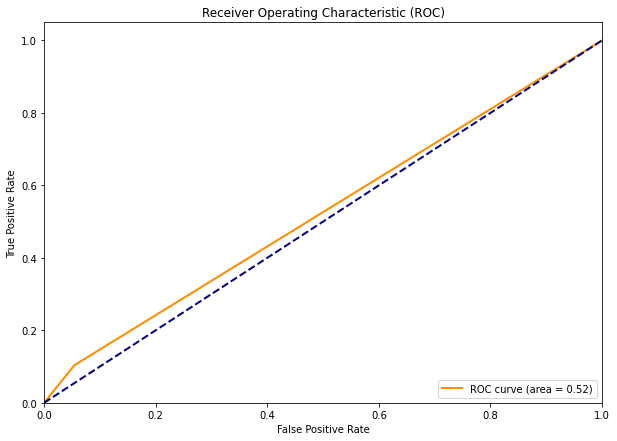

In [60]:
y_pred = best_model.predict(X_test)
evaluate(y_pred, y_test, group_test)

**Дерево с дополнительными фичами**

In [61]:
# Применяем ко всем наборам данных, добавляем необходимые метрики
additional_emb_columns = ['euclidean_dist', 'manhattan_dist', 'dot_product', 'chebyshev_dist']

X_train, y_train, group_train = prepare_data(df_train, additional_emb_cols=additional_emb_columns)
X_val, y_val, group_val = prepare_data(df_val, additional_emb_cols=additional_emb_columns)
X_test, y_test, group_test = prepare_data(df_test, additional_emb_cols=additional_emb_columns)

In [62]:
# Определение гиперпараметров для перебора
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # количество деревьев
    'max_depth': [5, 10, 20, None],  # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок для разделения
    'min_samples_leaf': [1, 2, 4]  # минимальное количество выборок в листе
}

# Функция для подбора гиперпараметров и обучения модели
def train_and_evaluate_rf(X_train, y_train, X_val, y_val, group_val, param_grid):
    best_ndcg = 0
    best_model = None
    best_params = None
    
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    # Инициализация модели с текущими гиперпараметрами
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        class_weight='balanced',
                        random_state=42,
                        n_jobs=-1
                    )
                    
                    # Обучение модели
                    model.fit(X_train, y_train)
                    
                    # Предсказание вероятностей для валидационного набора
                    y_pred_prob = model.predict_proba(X_val)[:, 1]
                    
                    # Подсчёт nDCG по группам
                    ndcg = calculate_ndcg_by_group(y_val, y_pred_prob, group_val)
                    
                    print(f"nDCG: {ndcg:.4f}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
                          f"min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}")
                    
                    # Сохранение наилучшей модели по nDCG
                    if ndcg > best_ndcg:
                        best_ndcg = ndcg
                        best_model = model
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf
                        }
    
    print(f"Best nDCG: {best_ndcg:.4f} with params: {best_params}")
    return best_model

# Запуск подбора гиперпараметров и обучения модели
best_model_rf = train_and_evaluate_rf(X_train, y_train, X_val, y_val, group_val, param_grid_rf)


nDCG: 0.6710, n_estimators: 50, max_depth: 5, min_samples_split: 2, min_samples_leaf: 1
nDCG: 0.6703, n_estimators: 50, max_depth: 5, min_samples_split: 2, min_samples_leaf: 2
nDCG: 0.6689, n_estimators: 50, max_depth: 5, min_samples_split: 2, min_samples_leaf: 4
nDCG: 0.6708, n_estimators: 50, max_depth: 5, min_samples_split: 5, min_samples_leaf: 1
nDCG: 0.6704, n_estimators: 50, max_depth: 5, min_samples_split: 5, min_samples_leaf: 2
nDCG: 0.6689, n_estimators: 50, max_depth: 5, min_samples_split: 5, min_samples_leaf: 4
nDCG: 0.6672, n_estimators: 50, max_depth: 5, min_samples_split: 10, min_samples_leaf: 1
nDCG: 0.6663, n_estimators: 50, max_depth: 5, min_samples_split: 10, min_samples_leaf: 2
nDCG: 0.6694, n_estimators: 50, max_depth: 5, min_samples_split: 10, min_samples_leaf: 4
nDCG: 0.6523, n_estimators: 50, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1
nDCG: 0.6484, n_estimators: 50, max_depth: 10, min_samples_split: 2, min_samples_leaf: 2
nDCG: 0.6583, n_estimators:

Average Precision: 0.2953
nDCG: 0.6020
ROC-AUC: 0.5021


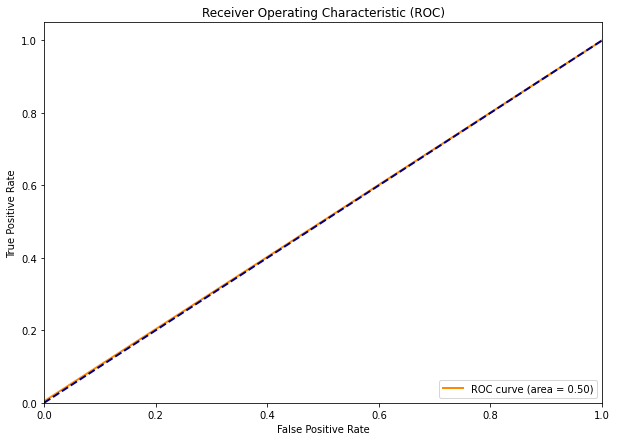

In [63]:
y_pred = best_model_rf.predict(X_test)
evaluate(y_pred, y_test, group_test)

**CatBoost**

In [64]:
import catboost as cb

# Применяем ко всем наборам данных, добавляем необходимые метрики
additional_emb_columns = []

X_train, y_train, group_train = prepare_data(df_train, additional_emb_cols=additional_emb_columns)
X_val, y_val, group_val = prepare_data(df_val, additional_emb_cols=additional_emb_columns)
X_test, y_test, group_test = prepare_data(df_test, additional_emb_cols=additional_emb_columns)

In [65]:
import catboost as cb

# Определение гиперпараметров для перебора
param_grid_catboost = {
    'iterations': [500, 1000],  # количество итераций
    'learning_rate': [0.01, 0.03, 0.1],  # скорость обучения
    'depth': [4, 6, 8],  # глубина деревьев
}

# Функция для подбора гиперпараметров и обучения модели
def train_and_evaluate_catboost(X_train, y_train, group_train, X_val, y_val, group_val, param_grid):
    best_ndcg = 0
    best_model = None
    best_params = None
    
    for iterations in param_grid['iterations']:
        for learning_rate in param_grid['learning_rate']:
            for depth in param_grid['depth']:
                # Инициализация модели с текущими гиперпараметрами
                catboost_ranker = cb.CatBoostRanker(
                    iterations=iterations,
                    learning_rate=learning_rate,
                    depth=depth,
                    verbose=100
                )
                
                # Подготовка данных в формате CatBoost
                train_pool = cb.Pool(data=X_train, label=y_train, group_id=group_train)
                val_pool = cb.Pool(data=X_val, label=y_val, group_id=group_val)
                
                # Обучение модели
                catboost_ranker.fit(train_pool, eval_set=val_pool)
                
                # Предсказание на валидационном наборе
                y_pred = catboost_ranker.predict(val_pool)
                
                # Подсчёт nDCG по группам
                ndcg = calculate_ndcg_by_group(y_val, y_pred, group_val)
                
                print(f"nDCG: {ndcg:.4f}, iterations: {iterations}, learning_rate: {learning_rate}, depth: {depth}")
                
                # Сохранение наилучшей модели по nDCG
                if ndcg > best_ndcg:
                    best_ndcg = ndcg
                    best_model = catboost_ranker
                    best_params = {
                        'iterations': iterations,
                        'learning_rate': learning_rate,
                        'depth': depth
                    }
    
    print(f"Best nDCG: {best_ndcg:.4f} with params: {best_params}")
    return best_model

# Запуск подбора гиперпараметров и обучения модели
best_model_catboost = train_and_evaluate_catboost(X_train, y_train, group_train, X_val, y_val, group_val, param_grid_catboost)


0:	test: 0.8040529	best: 0.8040529 (0)	total: 146ms	remaining: 1m 12s
100:	test: 0.8619719	best: 0.8640482 (77)	total: 4.29s	remaining: 16.9s
200:	test: 0.8652304	best: 0.8655046 (153)	total: 8.62s	remaining: 12.8s
300:	test: 0.8682903	best: 0.8687570 (299)	total: 13.3s	remaining: 8.76s
400:	test: 0.8718119	best: 0.8724855 (394)	total: 18.7s	remaining: 4.61s
499:	test: 0.8720840	best: 0.8735262 (448)	total: 23.3s	remaining: 0us

bestTest = 0.8735261512
bestIteration = 448

Shrink model to first 449 iterations.
nDCG: 0.6959, iterations: 500, learning_rate: 0.01, depth: 4
0:	test: 0.8238535	best: 0.8238535 (0)	total: 127ms	remaining: 1m 3s
100:	test: 0.8694866	best: 0.8712984 (87)	total: 7.88s	remaining: 31.1s
200:	test: 0.8705188	best: 0.8713147 (197)	total: 15.9s	remaining: 23.7s
300:	test: 0.8713287	best: 0.8732843 (283)	total: 24s	remaining: 15.9s
400:	test: 0.8729774	best: 0.8737391 (377)	total: 32.7s	remaining: 8.08s
499:	test: 0.8748914	best: 0.8752550 (476)	total: 41.8s	remaining

Average Precision: 0.4268
nDCG: 0.7009
ROC-AUC: 0.6182


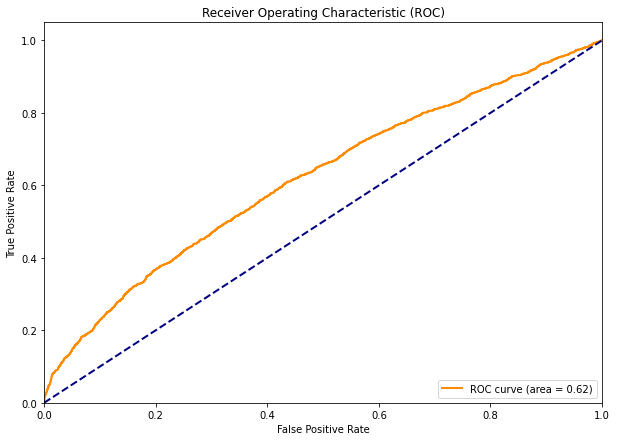

In [68]:
test_pool = cb.Pool(data=X_test, label=y_test, group_id=group_test)
y_pred = best_model_catboost.predict(test_pool)
evaluate(y_pred, y_test, group_test)